In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px


In [2]:
def mardia_test(df, imputed):
    # n; number of samples; p: number of variables (metabolites)
    n, p = df.shape
    # Substract each value its column mean
    data = df - df.mean()
    #Get covariance matrix inverted
    S = data.cov()
    SI = np.linalg.inv(S)
    
    
    # Check if inverse is right with identity matrix
    # df_SI = pd.DataFrame(SI)
    # df_SI.to_excel('SI.xlsx')
    # print(df_SI)
    # I =np.dot(S,SI)
    # df_I = pd.DataFrame(I)
    # df_I.to_excel('I.xlsx')
    
    # Turn NaN to 0 so when there are multiplications there's no problem
    data = data.replace(np.nan, 0)
    
    D = np.dot(np.dot(data, SI) , data.T)
    
    # Mardia test
    g1p = np.sum(D**3) / n**2
    g2p = np.sum(np.diag(D**2)) / n
    dfree = p * (p + 1) * (p + 2) / 6
    k = ((p + 1)*(n + 1)*(n + 3))/(n*((n + 1)*(p + 1) - 6))
    
    if n < 20:
        skew = n * k * g1p / 6
        p_skew = 1 - stats.chi2.cdf(skew, dfree)
    else:
        skew = n * g1p / 6
        p_skew = 1 - stats.chi2.cdf(skew, dfree)
    
    kurt = (g2p - p * (p + 2)) * np.sqrt(n/(8 * p * (p + 2)))
    p_kurt = 2 * (1 - stats.norm.cdf(abs(kurt)))
    
    skewMVN = "YES" if p_skew > 0.05 else "NO"
    kurtoMVN = "YES" if p_kurt > 0.05 else "NO"
    
    MVN = "YES" if p_kurt > 0.05 and p_skew > 0.05 else "NO"
    
    # result = np.column_stack((["Mardia"], g1p, skew, p_skew, skewMVN, g2p, kurt, p_kurt, kurtoMVN, MVN))
    # result = pd.DataFrame(result, columns=["test", "g1p", "chi.skew", "p.value.skew", "skewnewss", "g2p", "z.kurtosis", "p.value.kurt", "kurtosis", "MVN"])
    
    resultSkewness = pd.DataFrame({"Test": ["Mardia Skewness"], "Statistic": [skew], "p value": [p_skew], "Result": [skewMVN]})
    resultKurtosis = pd.DataFrame({"Test": ["Mardia Kurtosis"], "Statistic": [kurt], "p value": [p_kurt], "Result": [kurtoMVN]})
    MVNresult = pd.DataFrame({"Test": ["MVN"], "Statistic": [np.nan], "p value": [np.nan], "Result": [MVN]})
    
    result = pd.concat([resultSkewness, resultKurtosis, MVNresult], ignore_index=True)
    
    print(result)
   
    d = np.diag(D)
    r = stats.rankdata(d)
    # print(d,r)
    chi2q = stats.chi2.ppf((r - 0.5) / n, p)

    
    substraction = np.abs(chi2q - d)
    mean = np.mean(substraction)
    deviation = np.std(substraction)
    # print(substraction, mean, deviation)
    
    # Calculate upper/lower threshold 
    d_upper_limit = chi2q + mean + 2*deviation
    d_lower_limit = chi2q - mean - 2*deviation
    
    # Identify outliers
    outliers = d > d_upper_limit
    outliers |= d < d_lower_limit
    
    # Plot all dots
    plt.scatter(d[~outliers], chi2q[~outliers], marker='x', c='blue', label='Non-Outliers')
    plt.scatter(d[outliers], chi2q[outliers], marker='o', c='red', label='Outliers')
    
    # Label only outliers
    # for i, txt in enumerate(df.index):
    #     if outliers[i]: #If you add not will show NORMAL/TYPICAL VALUES
    #         plt.annotate(txt, (d[i], chi2q[i]))
    #         print(txt)
    for i, txt in enumerate(df.index):
        if outliers[i]: #If you add not will show NORMAL/TYPICAL VALUES
            plt.annotate(txt, (d[i], chi2q[i]))
            print(txt)
    
    # Line with slope 1 passing through the origin
    # x_line = np.linspace(81, 100, 100)  # Genera 100 puntos entre 0 y 1
    x_line = np.linspace(np.min(d), np.max(d), 100)  # 100 points between max and min values
    # If we use same ponits for both axes we get a line with slop 1 ;)
    plt.plot(x_line, x_line, color='green', linestyle='-', linewidth=2, label='Identity Line')
    plt.title("Chi-Square Q-Q Plot")
    plt.xlabel("Squared Mahalanobis Distance")
    plt.ylabel("Chi-Square Quantile")
    plt.legend()
    plt.grid(True)
    if imputed:
        plt.savefig('normality_imputed.tiff', dpi=300, format='tiff')
    if not imputed:
        plt.savefig('normality_not_imputed.tiff', dpi=300, format='tiff')
    plt.show()

    if not imputed:
        # Delete outliers
        df = df.drop(df.index[outliers])
        print(df)
        df.to_excel("data.xlsx")

               C0  C3-DC (C4-OH)        C9     C12:1    Ac-Orn  Putrescine  \
Sample                                                                       
c1       6.744444            NaN  0.012667  0.037000  0.263222    0.170111   
c2       7.400000            NaN  0.011000       NaN  0.051333    0.154000   
c3       7.733333            NaN       NaN  0.037000  0.260667    0.118333   
c4       7.466667            NaN  0.010667  0.046000  0.241667    0.120667   
c5       7.800000            NaN  0.014333  0.037000  0.366667    0.131667   
c6       8.466667       0.008333  0.011000  0.047000  0.613333    0.098000   
c7       3.400000            NaN       NaN       NaN  0.157000    0.070333   
c8       9.533333            NaN  0.011000  0.038667  0.291333    0.092000   
c9      14.083333       0.010500  0.010667  0.050500  0.303500    0.151167   
c10     10.033333       0.006500  0.011333  0.038333  0.255167    0.185167   
c11      5.727273            NaN       NaN  0.047273  0.135000  

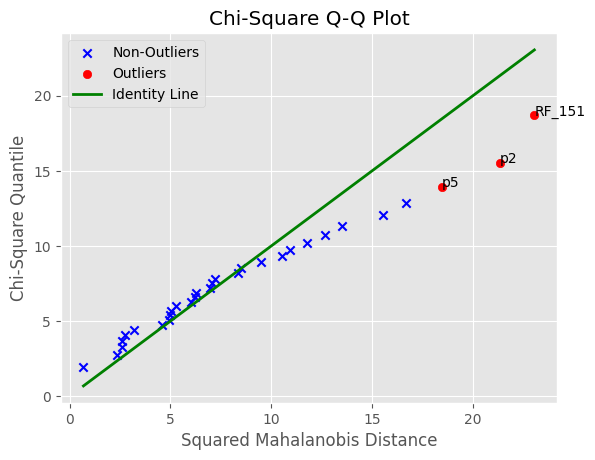

               C0  C3-DC (C4-OH)        C9     C12:1    Ac-Orn  Putrescine  \
Sample                                                                       
c1       6.744444            NaN  0.012667  0.037000  0.263222    0.170111   
c2       7.400000            NaN  0.011000       NaN  0.051333    0.154000   
c3       7.733333            NaN       NaN  0.037000  0.260667    0.118333   
c4       7.466667            NaN  0.010667  0.046000  0.241667    0.120667   
c5       7.800000            NaN  0.014333  0.037000  0.366667    0.131667   
c6       8.466667       0.008333  0.011000  0.047000  0.613333    0.098000   
c7       3.400000            NaN       NaN       NaN  0.157000    0.070333   
c8       9.533333            NaN  0.011000  0.038667  0.291333    0.092000   
c9      14.083333       0.010500  0.010667  0.050500  0.303500    0.151167   
c10     10.033333       0.006500  0.011333  0.038333  0.255167    0.185167   
c11      5.727273            NaN       NaN  0.047273  0.135000  

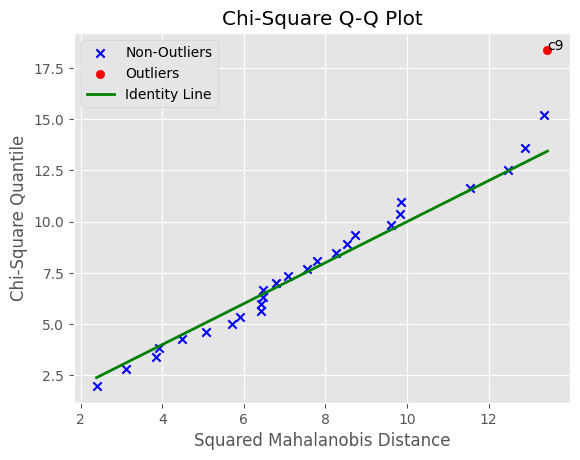

In [11]:
# Multivariate nomalization
df = pd.read_excel('PATH', sheet_name='Multivariate_2')

old_c = df.loc[df['Type'].str.startswith('V') & df['Disease'].str.startswith('C')]
old_pd = df.loc[df['Type'].str.startswith('V') & df['Disease'].str.startswith('P')]
new_c = df.loc[df['Type'].str.startswith('N') & df['Disease'].str.startswith('C')]
new_pd = df.loc[df['Type'].str.startswith('N') & df['Disease'].str.startswith('P')]
df = pd.concat([old_c, new_c, old_pd, new_pd], axis=0)

df = df[['Sample', "C0","C3-DC (C4-OH)","C9","C12:1","Ac-Orn","Putrescine","SDMA","Spermidine"]]
df.set_index('Sample', inplace=True)

print(df)
mardia_test(df, False)

# Read data without outliers
df = pd.read_excel("data.xlsx")
df.set_index('Sample', inplace=True)

# Multivariate imputation, variants -> https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html
imputer = KNNImputer(n_neighbors=5)
imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

imputed_df.to_excel("imputed_data.xlsx")
print(imputed_df)

mardia_test(imputed_df, True)

              C0  C3-DC (C4-OH)        C9     C12:1    Ac-Orn  Putrescine  \
Sample                                                                      
c1     -1.034484      -0.503110 -0.655481 -1.278809 -0.163518    0.138299   
c2     -0.770296      -0.503110 -0.977220 -0.073563 -1.046524   -0.114397   
c3     -0.635963      -0.503110 -0.697307 -1.278809 -0.174168   -0.673813   
c4     -0.743429      -0.503110 -1.041567  0.017671 -0.253347   -0.637215   
c5     -0.609097      -0.503110 -0.333742 -1.278809  0.267567   -0.464685   
c6     -0.340431      -0.435283 -0.977220  0.161724  1.295503   -0.992732   
c7     -2.382290      -0.503110 -0.632959  0.222401 -0.606179   -1.426672   
c8      0.089434      -0.105839 -0.977220 -1.038720 -0.046370   -1.086840   
c10     0.290933      -1.501131 -0.912872 -1.086738 -0.197088    0.374439   
c11    -1.444402      -0.503110 -0.632959  0.201012 -0.697859   -0.392449   
RF_137  0.660348      -1.355788 -0.156786 -0.162396 -0.232163   -0.514353   

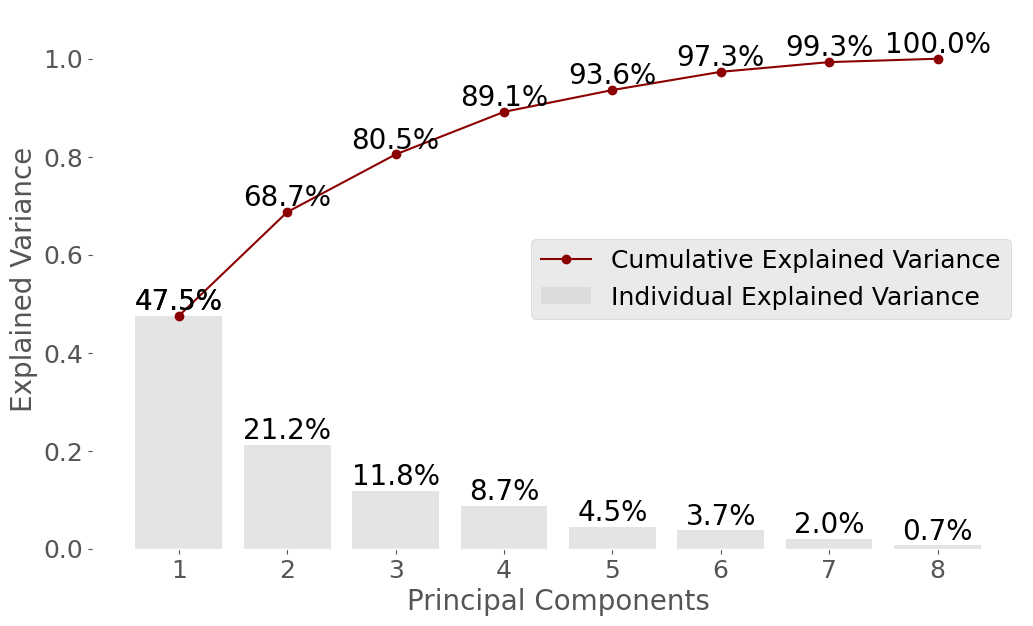

Principal Components:
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Sample                                                                         
c1     -1.724156  0.831685 -0.134795 -0.298885  0.154368  0.740398  0.624321   
c2     -1.763671  0.002681 -0.131743 -0.830561  0.209235  0.049981 -0.315741   
c3     -2.205115  0.307444  0.093078  0.310362 -0.110109  1.055537  0.234817   
c4     -1.413758  0.203760  0.392781 -0.675918 -0.056086 -0.121548 -0.464875   
c5     -0.738046  1.225836  0.360961  2.114305  0.851041 -0.458275  0.501532   
c6     -0.895396  0.402313  1.889282  1.058417 -0.347535 -0.044484 -0.097573   
c7     -3.231291 -0.918622  0.942650 -0.677812  0.262695 -0.214508  0.681411   
c8     -1.635826  0.182973  0.370120  0.772869  0.024622  1.065785 -0.568703   
c10    -0.855898  1.558149 -0.878043 -0.534553 -0.914527  0.224650 -0.561488   
c11    -2.043424 -0.393371  0.153030 -1.402702 -0.071299 -0.015459  0.216737   
RF_137 -0.470771  

Text(0.5, 1.0, 'Scree Plot')

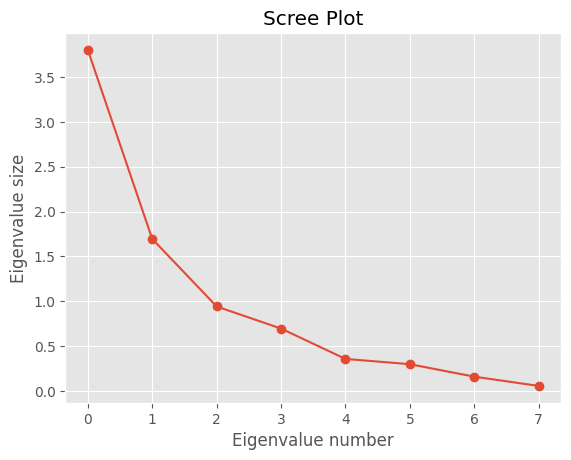

In [8]:
# PCA
df= pd.read_excel(r'PATH')
df.set_index('Sample', inplace=True)
df.drop('c9', inplace=True)

df = (df - df.mean()) / df.std()

print(df)

# Perform PCA
pca = PCA()
pca.fit(df)
list_pca = [f'PC{i+1}' for i in range(len(df.columns))]

# Save the percentage of variance explained by each PC
individual_variances = pca.explained_variance_ratio_
variance_df = pd.DataFrame(individual_variances, columns=['Explained Variance Ratio'], index=list_pca)

# n = number of PC you wanna show
n = 8

# Compute the cumulative explained variance
cumulative_variances = np.cumsum(individual_variances)

# Configuración del fondo blanco
plt.figure(figsize=(12, 7), facecolor='white')  # Establecer el fondo del gráfico
plt.axes().set_facecolor('white')  # Establecer el fondo de los ejes


# Create the bar plot for individual variances
# plt.figure(figsize=(12, 7))
bar = plt.bar(range(1, n + 1), individual_variances, alpha=0.6, color='lightgrey', label='Individual Explained Variance')

# Create the line plot for cumulative variance
line = plt.plot(range(1, n + 1), cumulative_variances, marker='o', linestyle='-', color='darkred', 
                label='Cumulative Explained Variance')

# Adding percentage values on top of bars and dots
for i, (bar, cum_val) in enumerate(zip(bar, cumulative_variances)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{individual_variances[i]*100:.1f}%', 
             ha='center', va='bottom', fontsize=20)
    plt.text(i+1, cum_val, f'{cum_val*100:.1f}%', ha='center', va='bottom', fontsize=20)

# Aesthetics for the plot
plt.tick_params(axis='both', labelsize=18) 
plt.xlabel('Principal Components', fontsize=20)
plt.ylabel('Explained Variance', fontsize=20)
# plt.title('Explained Variance by Different Principal Components')
plt.xticks(range(1, n + 1))
plt.legend(loc='center right', fontsize=18)
plt.ylim(0, 1.1)  # extend y-axis limit to accommodate text labels
plt.grid(True)
plt.savefig('PCA_exp_var.png', dpi=300, format='png')
plt.show()


# Create a DataFrame for the transformed values, PCs
df_pca = pd.DataFrame(pca.transform(df), index=df.index, columns=list_pca)
# Save the loadings of each PC in another DataFrame
loadings_df = pd.DataFrame(pca.components_.T, columns=list_pca, index=df.columns)


# Print the results
print("Principal Components:")
print(df_pca)
df_pca.to_excel("PCA.xlsx")
print("\nExplained Variance Ratio for each PC:")
print(variance_df)
variance_df.to_excel("variances.xlsx")
print("\nLoadings of each PC:")
print(loadings_df)
loadings_df.to_excel("loadings.xlsx")


# Identify PCs with explained variance ratio greater than 10%
relevant_pcs = variance_df[variance_df['Explained Variance Ratio'] > 0.1].index
variance_df.at['PC1', 'Explained Variance Ratio']

# Show the top 10 influential metabolites for each relevant PC
for pc in relevant_pcs:
    print(f"Top 10 metabolites for {pc}, with a {variance_df.at[pc, 'Explained Variance Ratio'] * 100:.2f}%' of the variance:")
    top_metabolites = loadings_df[pc].abs().nlargest(10)
    # Get real vales in case are negative
    top_metabolites = loadings_df.loc[top_metabolites.index, pc]
    for metabolite, value in top_metabolites.items():
        print(f"{metabolite}: {value:.4f}")
    print()

plt.style.use("ggplot") 
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

             PC1       PC2       PC3
Sample                              
c1     -1.724156  0.831685 -0.134795
c2     -1.763671  0.002681 -0.131743
c3     -2.205115  0.307444  0.093078
c4     -1.413758  0.203760  0.392781
c5     -0.738046  1.225836  0.360961
c6     -0.895396  0.402313  1.889282
c7     -3.231291 -0.918622  0.942650
c8     -1.635826  0.182973  0.370120
c10    -0.855898  1.558149 -0.878043
c11    -2.043424 -0.393371  0.153030
RF_137 -0.470771  0.455885 -0.295736
RF_138 -0.726184  1.457197 -1.399625
RF_140 -1.490720 -0.427385  0.425403
RF_141  0.745820 -2.179457 -1.377096
RF_142 -0.287921  0.106540 -0.607502
RF_143  0.434272  1.378293 -1.584452
RF_144 -0.581533 -0.969967 -0.746087
RF_146  1.302925 -0.795256  1.338364
p1      1.573983 -0.788244  0.554526
p3      3.361793  2.710148  1.203902
p4      3.701824  2.463137 -0.721372
RF_147  3.944705 -1.159348  0.602983
RF_148 -0.191292 -1.165236 -1.535544
RF_149  2.605919 -0.723319  0.863293
RF_152 -0.065380 -1.075315  1.271390
R

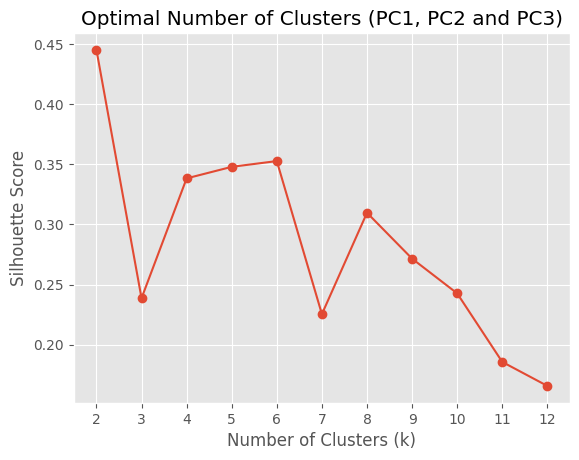

C:\Users\User\AppData\Local\Temp\ipykernel_4312\2913571694.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Clusters'] = best_cluster_labels


[0.63836676 0.66312731 0.64551172 0.64660376 0.52582168 0.40878375
 0.51598189 0.65463503 0.52049266 0.63740029 0.55896284 0.48793612
 0.62305208 0.07036411 0.51980224 0.28499906 0.49441276 0.13227681
 0.21157152 0.28966954 0.289285   0.47041457 0.37499125 0.43737425
 0.24835351 0.22319471]
[0.63836676 0.66312731 0.64551172 0.64660376 0.52582168 0.40878375
 0.51598189 0.65463503 0.52049266 0.63740029 0.55896284 0.48793612
 0.62305208 0.07036411 0.51980224 0.28499906 0.49441276 0.37499125
 0.24835351] [0.5010315170758499]
[0.13227681 0.21157152 0.28966954 0.289285   0.47041457 0.43737425
 0.22319471] [0.5010315170758499, 0.29339805679544073]


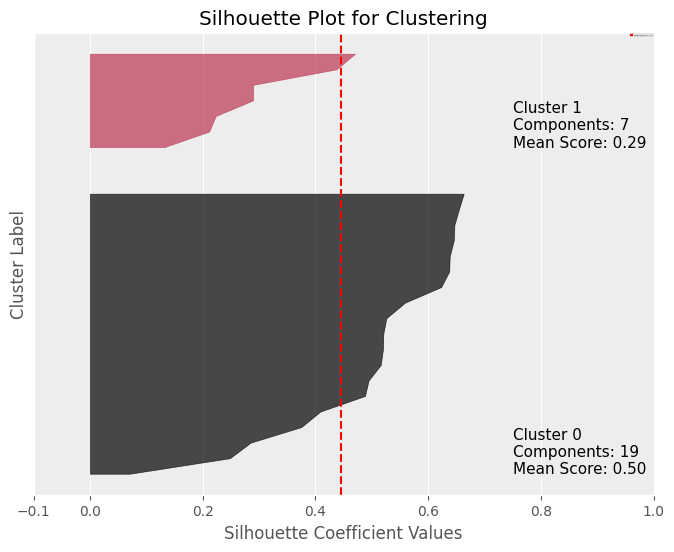

             PC1       PC2       PC3  Clusters
Sample                                        
c1     -1.724156  0.831685 -0.134795         0
c2     -1.763671  0.002681 -0.131743         0
c3     -2.205115  0.307444  0.093078         0
c4     -1.413758  0.203760  0.392781         0
c5     -0.738046  1.225836  0.360961         0
c6     -0.895396  0.402313  1.889282         0
c7     -3.231291 -0.918622  0.942650         0
c8     -1.635826  0.182973  0.370120         0
c10    -0.855898  1.558149 -0.878043         0
c11    -2.043424 -0.393371  0.153030         0
RF_137 -0.470771  0.455885 -0.295736         0
RF_138 -0.726184  1.457197 -1.399625         0
RF_140 -1.490720 -0.427385  0.425403         0
RF_141  0.745820 -2.179457 -1.377096         0
RF_142 -0.287921  0.106540 -0.607502         0
RF_143  0.434272  1.378293 -1.584452         0
RF_144 -0.581533 -0.969967 -0.746087         0
RF_146  1.302925 -0.795256  1.338364         1
p1      1.573983 -0.788244  0.554526         1
p3      3.361

In [27]:
# Clustering analysis
pca = pd.read_excel(r'PATH')
df = pca[['Sample', 'PC1', 'PC2', 'PC3']]
df.set_index('Sample', inplace=True)


print(df)

# Calculate silhouette score for different number of clusters (k) using KMeans
silhouette_scores = []
clusters_range = range(2, 13)  # Range of clusters to try
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[['PC1', 'PC2', 'PC3']])
    silhouette_avg = silhouette_score(df[['PC1', 'PC2', 'PC3']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores for different number of clusters
# plt.figure(figsize=(10, 6))
plt.plot(clusters_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters (PC1, PC2 and PC3)')
plt.xticks(clusters_range)
plt.grid(True)
plt.savefig('score_for_diff_clusters.tiff', dpi=300, format='tiff')
plt.show()

# Find the best number of clusters
best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 because it starts from 2 clusters

# Clustering using kmeans with the best number of clusters
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
best_cluster_labels = best_kmeans.fit_predict(df[['PC1', 'PC2', 'PC3']])
df.loc[:, 'Clusters'] = best_cluster_labels


X = df[['PC1', 'PC2', 'PC3']].values
cluster_labels = df.loc[:, 'Clusters'].values

# Calculate silhouette scores for each sample
silhouette_scores = silhouette_samples(X, cluster_labels)
print(silhouette_scores)

# Create lists to store the number of components and mean silhouette scores for each cluster
num_components = []
mean_silhouette_scores = []

# Calculate number of components and mean silhouette score for each cluster
for i in np.unique(cluster_labels):
    cluster_silhouette_scores = silhouette_scores[cluster_labels == i]
    num_samples = cluster_silhouette_scores.shape[0]
    num_components.append(num_samples)
    mean_silhouette_scores.append(np.mean(cluster_silhouette_scores))
    print(cluster_silhouette_scores, mean_silhouette_scores)


# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))

y_lower = 10
for i, (num_comp, mean_score) in enumerate(zip(num_components, mean_silhouette_scores)):
    # Aggregate the silhouette scores for samples belonging to cluster i and sort them
    cluster_silhouette_scores = silhouette_scores[cluster_labels == i]
    cluster_silhouette_scores.sort()

    size_cluster_i = cluster_silhouette_scores.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.inferno(float(i) / len(np.unique(cluster_labels)))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_scores,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(0.75, y_lower + 0.0 * size_cluster_i, f"Cluster {i}\nComponents: {num_comp}\nMean Score: {mean_score:.2f}", fontsize=11)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 2

    # Print samples that their silhouette score is negative
    for idx, score in enumerate(cluster_silhouette_scores):
        if score < 0:  # Si el valor de la silueta es negativo, imprimir el nombre de la fila
            sample_name = df.index[cluster_labels == i][idx]  # Obtener el nombre de la fila correspondiente al índice
            print(f"Sample with negative score: {sample_name}")

ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.set_facecolor((0.9, 0.9, 0.9, 0.7))

# The vertical line for average silhouette score of all the values
ax.axvline(x=np.mean(silhouette_scores), color="red", linestyle="--", label=f'General Mean Score: {np.mean(silhouette_scores):.2f}')
ax.legend(loc="upper right", fontsize=1)

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

ax.set_title("Silhouette Plot for Clustering")
plt.savefig('silhouette_for_opt_clusters.tiff', dpi=300, format='tiff')
plt.show()

print(df)
df.to_excel("Clusters.xlsx")
#'''

In [31]:
# Plot best numer of PCs withe the clusters generated with Kmeans

df= pd.read_excel(r'PATH')
type_sample = pd.read_excel('PATH', sheet_name='Data_4')
type_sample = type_sample[['Sample', 'Disease']]
df = pd.merge(df, type_sample, on='Sample', how='inner')
df = df[df['Sample'] != 'c9']
df['Disease_2'] = df['Disease'].apply(lambda x: 'P' if x.startswith('P') else 'C')

print(df)

# Don't set Sample column as row's indexes, must be used!
fig = px.scatter_3d(
    data_frame=df,
    x='PC1',
    y='PC2',
    z='PC3',
    color="Disease_2",
    color_discrete_sequence=['black', 'darkred'],
    # color_discrete_map={'Europe': 'black', 'Africa': 'yellow'},
    opacity=0.5,              # opacity values range from 0 to 1
    symbol='Clusters',            # symbol used for bubble
    # symbol_map={"2005": "square-open", "2010": 3},
    # size='resized_pop',       # size of bubble
    # size_max=50,              # set the maximum mark size when using size
    # log_x=True,  # you can also set log_y and log_z as a log scale
    # range_z=[9,13],           # you can also set range of range_y and range_x
    template='ggplot2',         # 'ggplot2', 'seaborn', 'simple_white', 'plotly',
                                # 'plotly_white', 'plotly_dark', 'presentation',
                                # 'xgridoff', 'ygridoff', 'gridon', 'none'
    title='3 firsts PC',
    #labels={'Years in school (avg)': 'Years Women are in School'},
    # hover_data={'Continent': False, 'GDP per capita': ':.1f'},
    hover_name='Sample',        # values appear in bold in the hover tooltip
    height=700,                 # height of graph in pixels

    # animation_frame='Year',   # assign marks to animation frames
    # range_x=[500,100000],
    # range_z=[0,14],
    # range_y=[5,100]
)
# pio.show(fig)
fig.write_html("3dPlot.html")

    Sample       PC1       PC2       PC3  Clusters Disease Disease_2
0       c1 -1.724156  0.831685 -0.134795         0       C         C
1       c2 -1.763671  0.002681 -0.131743         0       C         C
2       c3 -2.205115  0.307444  0.093078         0       C         C
3       c4 -1.413758  0.203760  0.392781         0       C         C
4       c5 -0.738046  1.225836  0.360961         0       C         C
5       c6 -0.895396  0.402313  1.889282         0       C         C
6       c7 -3.231291 -0.918622  0.942650         0       C         C
7       c8 -1.635826  0.182973  0.370120         0       C         C
8      c10 -0.855898  1.558149 -0.878043         0       C         C
9      c11 -2.043424 -0.393371  0.153030         0       C         C
10  RF_137 -0.470771  0.455885 -0.295736         0       C         C
11  RF_138 -0.726184  1.457197 -1.399625         0       C         C
12  RF_140 -1.490720 -0.427385  0.425403         0       C         C
13  RF_141  0.745820 -2.179457 -1.

In [7]:
# Plot for just 1 PC
# df= pd.read_excel(r'C:\Users\User\Documents\Universidad\6º Carrera\Practicas\Metabolomic\Humor_aq\Multivariate\raw_data\Clusters.xlsx')
# type_sample = pd.read_excel('C:/Users/User/Documents/Universidad/6º Carrera/Practicas/Metabolomic/Data/2024-03-22_Conc_Plate4_HUMORAC_curated.xlsx', sheet_name='Data_4')
# type_sample = type_sample[['Sample', 'Disease']]
# df = pd.merge(df, type_sample, on='Sample', how='inner')


# print(df)

# import seaborn as sns
# sns.set(style='whitegrid')
# # Plot each sample
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='PC1', y=0, hue='Clusters', data=df, palette='pastel', s=100)

# # Add label for each sample
# for i, row in df.iterrows():
#     plt.text(row['PC1'], 0, row['Sample'], fontsize=8, ha='center', va='bottom', rotation ='vertical')

# plt.xlabel('PC1')
# plt.title('PC1 for each sample')
# plt.legend(title='Clusters')

# plt.show()

In [16]:
# Multivariate nomalization
df = pd.read_excel('PATH', sheet_name='Multivariate_2')

old_c = df.loc[df['Type'].str.startswith('V') & df['Disease'].str.startswith('C')]
old_pd = df.loc[df['Type'].str.startswith('V') & df['Disease'].str.startswith('P')]
new_c = df.loc[df['Type'].str.startswith('N') & df['Disease'].str.startswith('C')]
new_pd = df.loc[df['Type'].str.startswith('N') & df['Disease'].str.startswith('P')]
df = pd.concat([old_c, new_c, old_pd, new_pd], axis=0)

df = df[['Sample', "C0","C3-DC (C4-OH)","C9","C12:1","Ac-Orn","Putrescine","SDMA","Spermidine"]]
df.set_index('Sample', inplace=True)

import missingno as msno
msno.matrix(df, figsize=(10, 5))
plt.savefig('missing_values.tiff', dpi=300, format='tiff')




C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(
